https://catalog.data.gov/dataset/3-year-recidivism-for-offenders-released-from-prison

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, neighbors, grid_search, cross_validation
from sklearn import model_selection


sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))
%matplotlib inline
plt.style.use('ggplot')




/Users/matanefron/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/matanefron/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# read in dataset
df = pd.read_csv('/Users/matanefron/Downloads/3-Year_Recidivism_for_Offenders_Released_from_Prison.csv')

In [3]:
#Set recidivism to true or false
df['Recidivism'] = df['Recidivism - Return to Prison']=='Yes'
#Change it to binary
df.Recidivism = df.Recidivism.astype(int)



In [259]:
df.head(1)

,Offender,Recidivism Reporting Year,Race - Ethnicity,Sex,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Release Type,Main Supervising District,Recidivism - Return to Prison,Recidivism Type,Days to Recidivism,New Conviction Offense Classification,New Conviction Offense Type,New Conviction Offense Sub Type,Part of Target Population,Recidivism
0,1,FY13,White - Non-Hispanic,M,Under 25,D Felony,Violent,Assault,Parole,4JD,Yes,Tech,16.0,NaN,NaN,NaN,Yes,1


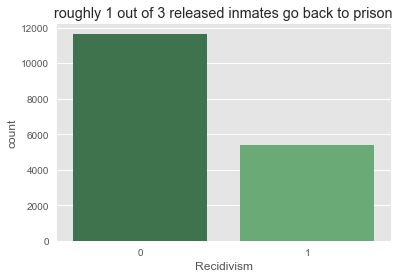

In [4]:
ax = plt.axes()
sns.countplot(x="Recidivism", data=df, palette="Greens_d")
ax.set_title('roughly 1 out of 3 released inmates go back to prison')
plt.show()


#1963

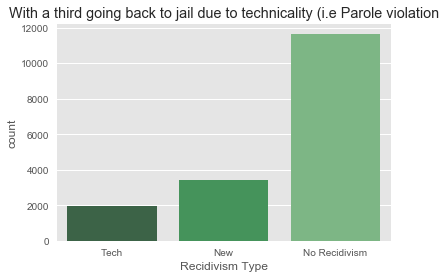

Recidivism Type
New               3441
No Recidivism    11656
Tech              1963
Name: Recidivism, dtype: int64

In [81]:
ax = plt.axes()
sns.countplot(x="Recidivism Type", data=df, palette="Greens_d")
ax.set_title('With a third going back to jail due to technicality (i.e Parole violation')
plt.show()


df.groupby('Recidivism Type')['Recidivism'].count()



In [14]:
# Create two new tables with Recidivism Y and for ease of future calcs
df_rec_y = df[df['Recidivism']==1]
df_rec_n = df[df['Recidivism']==0]



In [15]:
# Recidivism by Race

print "Count Recidivism by Race"

print df.groupby('Race - Ethnicity')['Recidivism'].count()



Count Recidivism by Race
Race - Ethnicity
American Indian or Alaska Native - Hispanic           14
American Indian or Alaska Native - Non-Hispanic      318
Asian or Pacific Islander - Hispanic                   2
Asian or Pacific Islander - Non-Hispanic             126
Black -                                                2
Black - Hispanic                                      26
Black - Non-Hispanic                                4078
N/A -                                                  4
White -                                               11
White - Hispanic                                    1030
White - Non-Hispanic                               11419
Name: Recidivism, dtype: int64


In [16]:
#Reduce race categories

def classify_race(x):
    if x == 'White - ' or x=='White - Non-Hispanic':
        return 'white'
    elif x == 'Black - ' or x=='Black - Non-Hispanic' :
        return 'black'
    elif x == 'N/A -' or x=='American Indian or Alaska Native - Non-Hispanic':
        return 'other'
    elif x == 'Asian or Pacific Islander - Non-Hispanic':
        return 'other'
    else:
        return 'Hispanic'



In [17]:
#Map back 
df['Race'] = df['Race - Ethnicity'].map(classify_race)

df_rec_y['Race'] = df_rec_y['Race - Ethnicity'].map(classify_race)
df_rec_n['Race'] = df_rec_n['Race - Ethnicity'].map(classify_race)

/Users/matanefron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/matanefron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Axes(0.125,0.125;0.775x0.755)


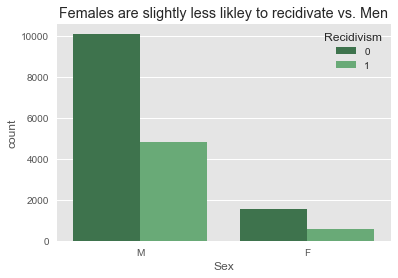

% Recidivism by Gender


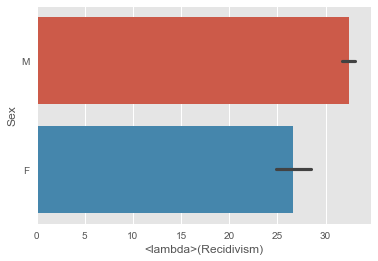

In [83]:
ax = plt.axes()
print sns.countplot(x="Sex",hue="Recidivism", data=df, palette="Greens_d");
ax.set_title('Females are slightly less likley to recidivate vs. Men')



plt.show()
 
print "% Males are more likely to get re-admitted to prison" 
    
sns.barplot(x='Recidivism', y='Sex', data=df, estimator=lambda x: sum(x==1)*1.0/len(x)*100)

plt.show()



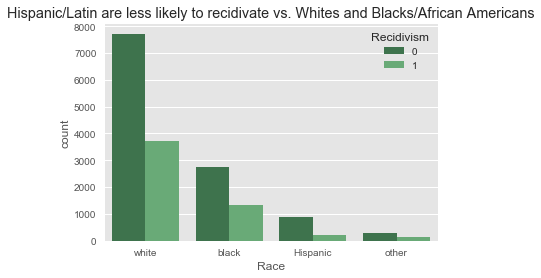

% Whites and Black are more likely to get re-admitted vs. Hispanic


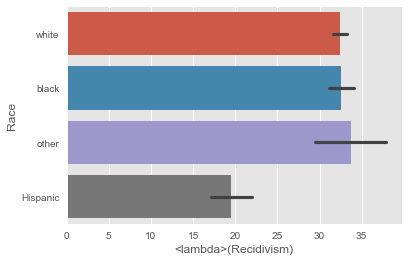

In [99]:
ax = plt.axes()
sns.countplot(x="Race",hue="Recidivism",order =('white','black','Hispanic','other'),data=df, palette="Greens_d");
ax.set_title('Hispanic/Latin are less likely to recidivate vs. Whites and Blacks/African Americans')


plt.show()

print "% Whites and Blacks are more likely to get re-admitted vs. Hispanic" 

sns.barplot(x='Recidivism', y='Race', data=df, estimator=lambda x: sum(x==1)*1.0/len(x)*100)

plt.show()


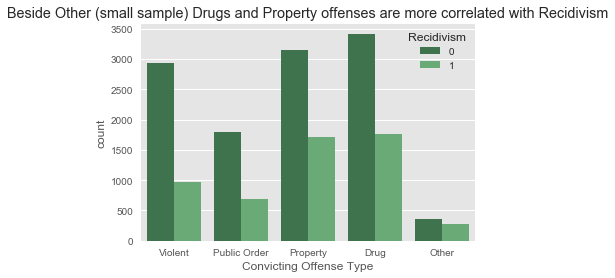

% Recidivism by Convicting Offense Type


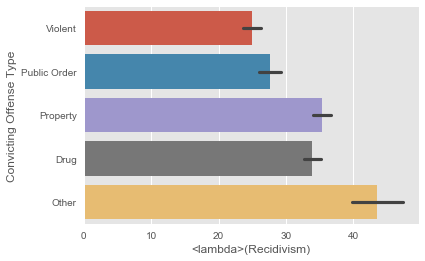

In [96]:
ax = plt.axes()
sns.countplot(x="Convicting Offense Type",hue="Recidivism", data=df, palette="Greens_d");

ax.set_title('Beside Other (small sample) Drugs and Property offenses are more correlated with Recidivism')


plt.show()


print "% Recidivism by Convicting Offense Type" 

sns.barplot(x='Recidivism', y='Convicting Offense Type', data=df, estimator=lambda x: sum(x==1)*1.0/len(x)*100)

plt.show()


##If we want to print % table

#print np.round(100*pd.to_numeric(df_rec_y.groupby('Convicting Offense Type')['Recidivism'].count(),errors='coerce')
#                    /df.groupby('Convicting Offense Type')['Recidivism'].count()).astype(str)+ "%"


Recidivism by Gender X Offense Type


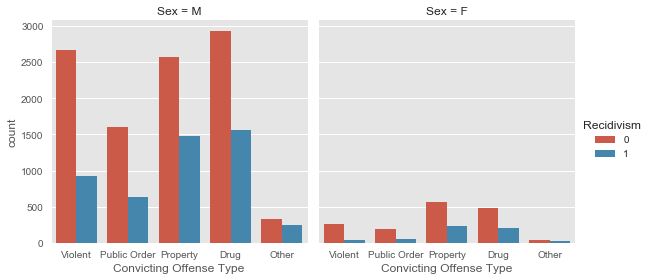

% Recidivism by Gender X Convicting Offense Type


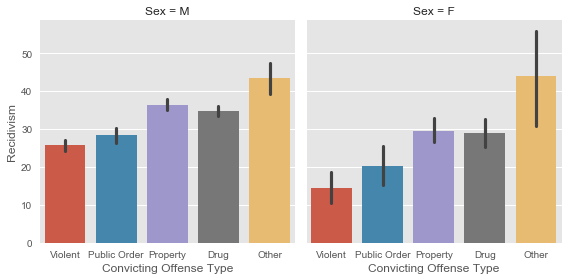

In [97]:
print "Recidivism by Gender X Offense Type"

sns.factorplot(
    col= 'Sex',
    x = 'Convicting Offense Type',
    hue = 'Recidivism',
    data=df,
    kind='count',
)

plt.show()


print '% Recidivism by Gender X Convicting Offense Type'


sns.factorplot(
    col= 'Sex',
    x = 'Convicting Offense Type',
    y = 'Recidivism',
    data=df,
    estimator=lambda x: sum(x==1)*1.0/len(x)*100,
    kind='bar',)



plt.show()


#if we want to print the % table

#print "% Recidivism by Age of Release" 
#print np.round(100*pd.to_numeric(df_rec_y.groupby('Age At Release ')['Recidivism'].count(),errors='coerce')
#                    /df.groupby('Age At Release ')['Recidivism'].count()).astype(str)+ "%"


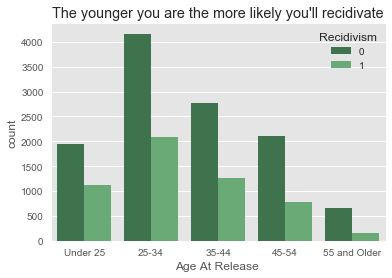

% Recidivism by Age of Release


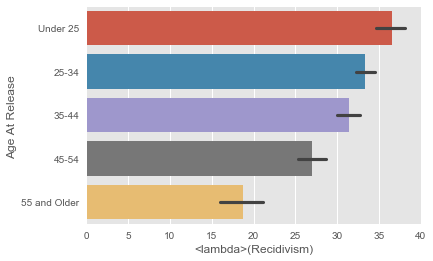

In [91]:
ax = plt.axes()
sns.countplot(x="Age At Release ",hue="Recidivism",order=('Under 25','25-34','35-44','45-54','55 and Older'), data=df, palette="Greens_d");

ax.set_title('The younger you are the more likely you\'ll recidivate')


plt.show()


print "% Recidivism by Age of Release" 

sns.barplot(x='Recidivism', y='Age At Release ', data=df, order=('Under 25','25-34','35-44','45-54','55 and Older'),estimator=lambda x: sum(x==1)*1.0/len(x)*100)

plt.show()

#if we want to print the % table

#print "% Recidivism by Age of Release" 
#print np.round(100*pd.to_numeric(df_rec_y.groupby('Age At Release ')['Recidivism'].count(),errors='coerce')
#                    /df.groupby('Age At Release ')['Recidivism'].count()).astype(str)+ "%"


Females are at higher risk of Recidivism between 25-44 vs. Male population with highest risk at under 25


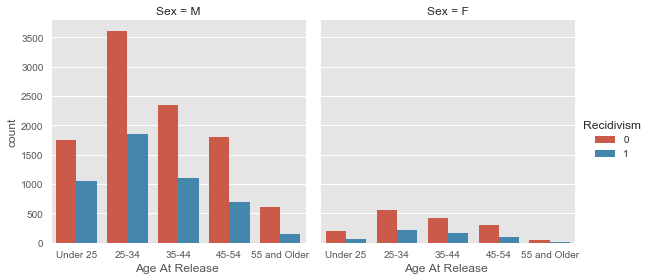

% Recidivism by Sex X Age of Release


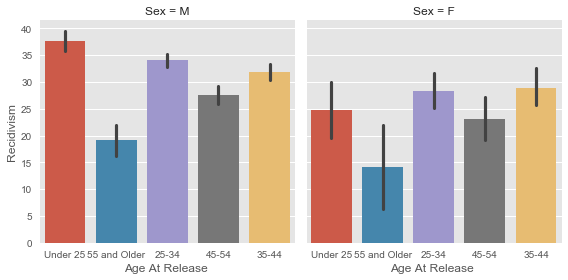

In [100]:
print "Females are at higher risk of Recidivism between 25-44 vs. Male population with highest risk at under 25"
sns.factorplot(
    col= 'Sex',
    x='Age At Release ',
    hue = 'Recidivism',
    order=('Under 25','25-34','35-44','45-54','55 and Older'),
    data=df,
    kind='count',
)

plt.show()


print '% Recidivism by Sex X Age of Release'

sns.factorplot(
    col= 'Sex',
    x = 'Age At Release ',
    y = 'Recidivism',
    #hue = '',
    #order=('Under 25','25-34','35-44','45-54','55 and Older'),
    data=df,
    estimator=lambda x: sum(x==1)*1.0/len(x)*100,
    kind='bar',)


plt.show()


#if we want to print the % table

#dfy =pd.to_numeric(df_rec_y.groupby(['Sex','Age At Release '])['Recidivism'].count(),errors='coerce')
#dfn = df.groupby(['Sex','Age At Release '])['Recidivism'].count()

#np.round(100*dfy/dfn).astype(str) + "%"


Recidivism by Offense type X Race


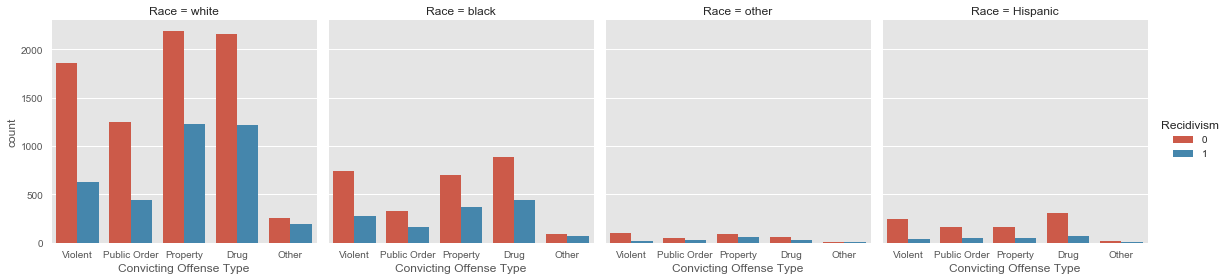

% Recidivism by Race X Convicting Offense Type


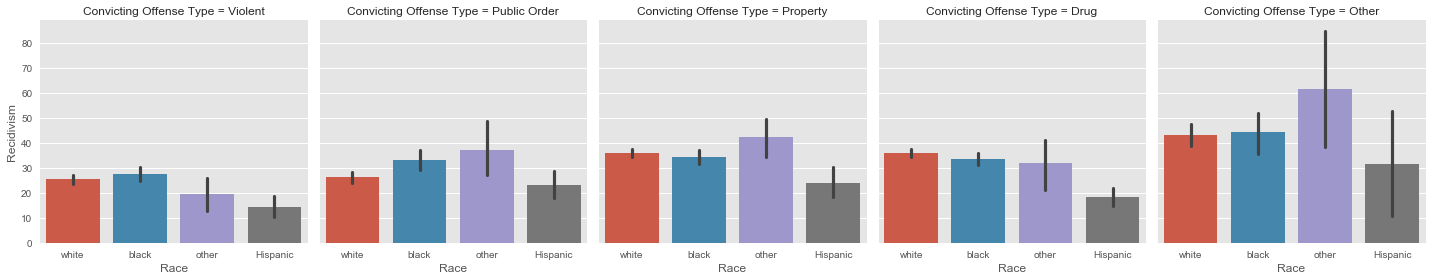

In [101]:
print "Recidivism by Offense type X Race"

sns.factorplot(
    col= 'Race',
    x='Convicting Offense Type',
    hue = 'Recidivism',
    data=df,
    kind='count',
)

plt.show()


print '% Recidivism by Race X Convicting Offense Type'

sns.factorplot(
    col= 'Convicting Offense Type',
    x = 'Race',
    y = 'Recidivism',
    #hue = '',
    #order=('Under 25','25-34','35-44','45-54','55 and Older'),
    data=df,
    estimator=lambda x: sum(x==1)*1.0/len(x)*100,
    kind='bar',)


plt.show()

#if we want to print the %

#dfy2 =pd.to_numeric(df_rec_y.groupby(['Race','Convicting Offense Type'])['Recidivism'].count(),errors='coerce')
#dfn2 = df.groupby(['Race','Convicting Offense Type'])['Recidivism'].count()

#np.round(100*dfy2/dfn2).astype(str) + "%"



Recidivism by Offense type X Age of Release


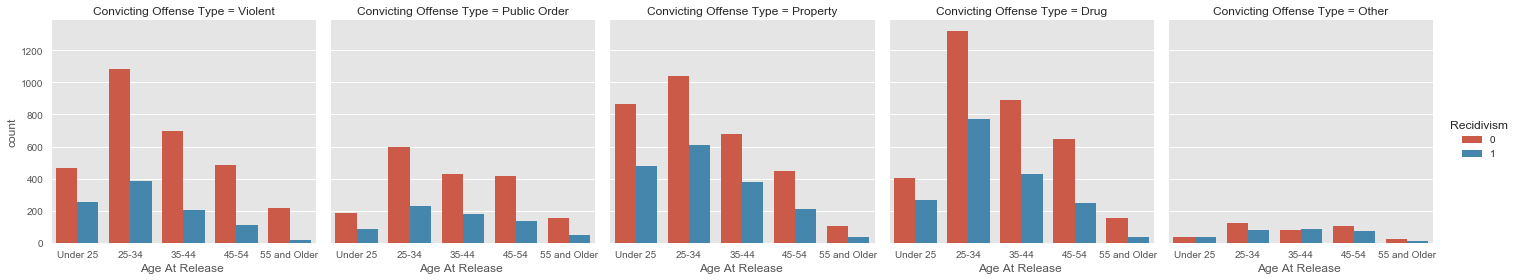

In [85]:
print "Recidivism by Offense type X Age of Release"

sns.factorplot(
    col= 'Convicting Offense Type',
    x = 'Age At Release ',
    hue = 'Recidivism',
    order=('Under 25','25-34','35-44','45-54','55 and Older'),
    data=df,
    kind='count',
)

plt.show()



print '% Recidivism by Offense Type X Age of Release'


sns.factorplot(
    col= 'Convicting Offense Type',
    x = 'Age At Release ',
    y = 'Recidivism',
    #hue = '',
    order=('Under 25','25-34','35-44','45-54','55 and Older'),
    data=df,
    estimator=lambda x: sum(x==1)*1.0/len(x)*100,
    kind='bar',)

plt.show()


#if we want to print the % table

#dfy2 =pd.to_numeric(df_rec_y.groupby(['Convicting Offense Type','Age At Release ' ])['Recidivism'].count(),errors='coerce')
#dfn2 = df.groupby(['Convicting Offense Type','Age At Release '])['Recidivism'].count()

#np.round(100*dfy2/dfn2).astype(str) + "%"




In [23]:
df.groupby(['Release Type']).agg({'Recidivism':[np.size]})

,Recidivism
,size
Release Type,
Discharged - Expiration of Sentence,1215
Discharged – End of Sentence,5039
Interstate Compact Parole,1
Parole,6986
Parole Granted,2883
Paroled to Detainer - INS,81
Paroled to Detainer - Iowa,41
Paroled to Detainer - Out of State,56


In [102]:
# Group Release Type
def classify_release_type(x):
    if x == 'Discharged - Expiration of Sentence' or x=='Discharged – End of Sentence':
        return 'Discharged'
    elif x == 'Special Sentence' or x=='Released to Special Sentence' :
        return 'Special Sentence'
    else:
        return 'Paroled'



In [103]:
df['Release Type2'] = df['Release Type'].map(classify_release_type)
df_rec_y['Release Type2'] = df_rec_y['Release Type'].map(classify_release_type)
df_rec_n['Release Type2'] = df_rec_n['Release Type'].map(classify_release_type)

/Users/matanefron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/matanefron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [104]:
df.groupby(['Release Type2']).agg({'Recidivism':[np.size]})

,Recidivism
,size
Release Type2,
Discharged,6254
Paroled,10287
Special Sentence,519


Axes(0.125,0.125;0.775x0.755)


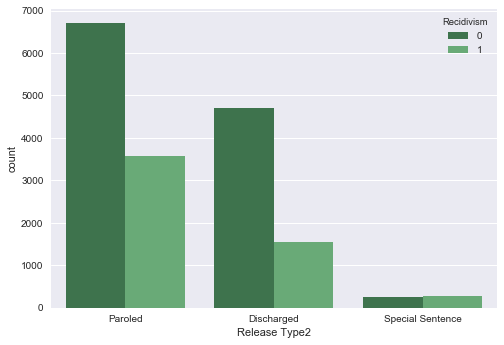

% Recidivism by release type


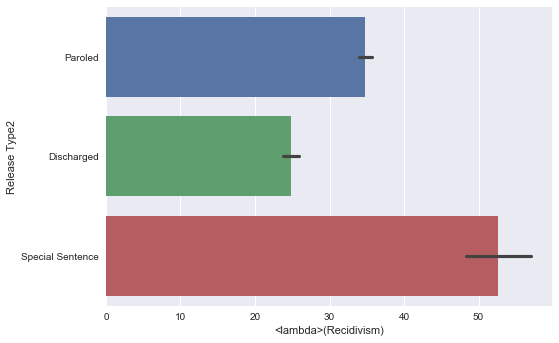

In [107]:
# Recidivism by Release Type 
sns.set(font_scale=1)  
fig, ax = plt.subplots()

print sns.countplot(x="Release Type2",hue="Recidivism", data=df, palette="Greens_d");

plt.show()

print "% Recidivism by release type" 
    
sns.barplot(x='Recidivism', y='Release Type2', data=df, estimator=lambda x: sum(x==1)*1.0/len(x)*100)

plt.show()


Recidivism by release type X Race


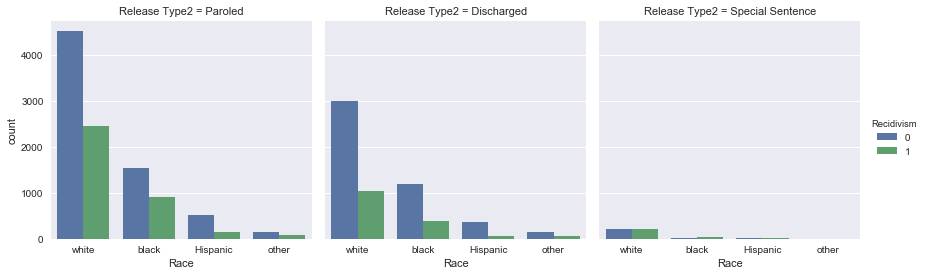

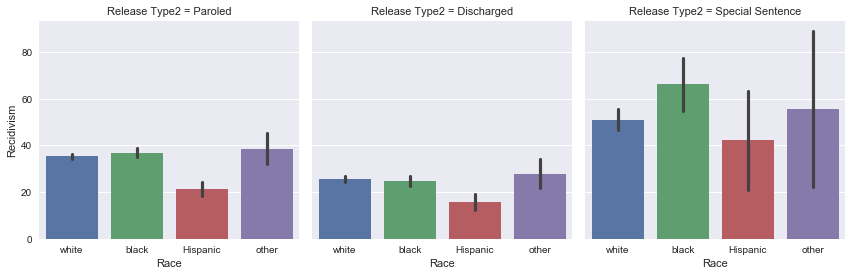

In [111]:
print "Recidivism by release type X Race"

sns.factorplot(
    col= 'Release Type2',
    x='Race',
    hue = 'Recidivism',
    data=df,
    order = ('white', 'black', 'Hispanic', 'other'),
    kind='count',
)

plt.show()

sns.factorplot(
    col= 'Release Type2',
    x = 'Race',
    y = 'Recidivism',
    data=df,
    order = ('white', 'black', 'Hispanic', 'other'),
    estimator=lambda x: sum(x==1)*1.0/len(x)*100,
    kind='bar',)

plt.show()



In [113]:
cols_to_transform = df[['Race','Age At Release ','Sex','Release Type2','Convicting Offense Type',
                        'Convicting Offense Subtype','Convicting Offense Classification','Main Supervising District']]

In [114]:
cols_to_transform.head(1)

,Race,Age At Release,Sex,Release Type2,Convicting Offense Type,Convicting Offense Subtype,Convicting Offense Classification,Main Supervising District
0,white,Under 25,M,Paroled,Violent,Assault,D Felony,4JD


In [118]:
y = df['Recidivism'].values

In [119]:
X = pd.get_dummies(cols_to_transform)
X.head(1)

,Race_Hispanic,Race_black,Race_other,Race_white,Age At Release _25-34,Age At Release _35-44,Age At Release _45-54,Age At Release _55 and Older,Age At Release _Under 25,Sex_F,...,Main Supervising District_1JD,Main Supervising District_2JD,Main Supervising District_3JD,Main Supervising District_4JD,Main Supervising District_5JD,Main Supervising District_6JD,Main Supervising District_7JD,Main Supervising District_8JD,Main Supervising District_ISC,Main Supervising District_Interstate Compact
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [120]:
from sklearn.cross_validation import train_test_split

trainX, testX, trainY, testY = train_test_split(X, y, train_size = .25)
print trainX.shape, testX.shape
print trainY.shape, testY.shape

(4265, 69) (12795, 69)
(4265,) (12795,)


# random forest model

In [121]:
##Need to add Gridserach
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators = 20)

In [122]:
# No optimization
model_rf.fit(trainX,trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [123]:
y_predict = model_rf.predict(testX)

In [124]:
from sklearn.metrics import confusion_matrix, classification_report

cnf_mtx = confusion_matrix(testY, y_predict)
print cnf_mtx

print classification_report(testY, y_predict)

[[7220 1523]
 [2889 1163]]
             precision    recall  f1-score   support

          0       0.71      0.83      0.77      8743
          1       0.43      0.29      0.35      4052

avg / total       0.63      0.66      0.63     12795



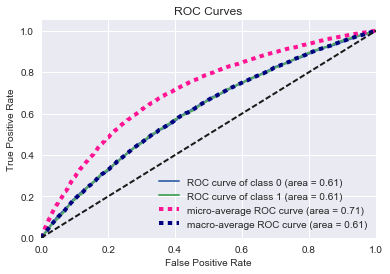

In [125]:
%matplotlib inline

# This is all that's needed for scikit-plot
import matplotlib.pyplot as plt
from scikitplot import classifier_factory

classifier_factory(model_rf)

model_rf.plot_roc_curve(X.as_matrix(), y, random_state=2)
plt.show()

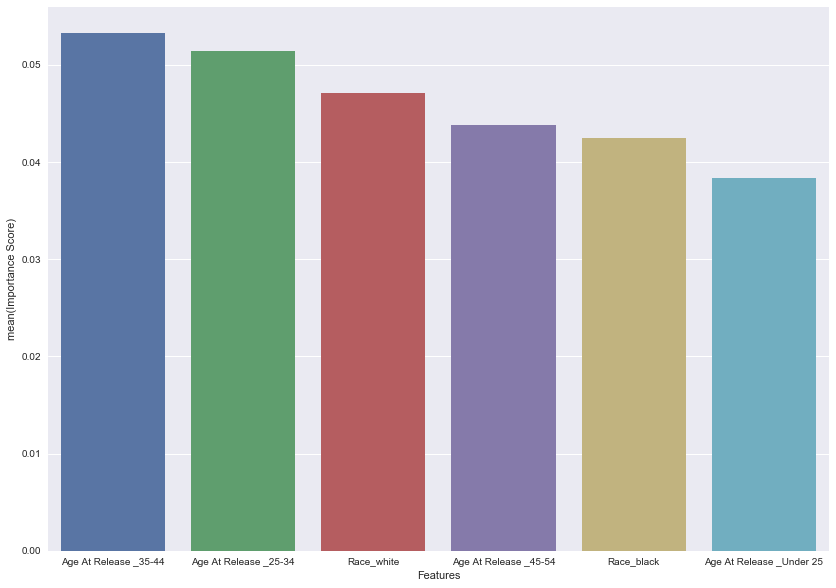

In [155]:
features = X.columns
feature_importances = model_rf.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values(by='Importance Score', inplace=True, ascending=False)

features_df.head(10)


#Plot top features
a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(x="Features", y="Importance Score", data=features_df.head(6));

plt.show()

### Improving Model with Gridsearch

In [148]:
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [149]:
param_grid = {"max_depth": [10, None],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "warm_start": [True, False],
              "criterion": ["gini", "entropy"]}


gs = GridSearchCV(model_rf, param_grid=param_grid)
start = time()
gs.fit(trainX,trainY)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(gs.cv_results_['params'])))
report(gs.cv_results_)

GridSearchCV took 79.71 seconds for 144 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.688 (std: 0.002)
Parameters: {'warm_start': False, 'bootstrap': True, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 5, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.687 (std: 0.002)
Parameters: {'warm_start': False, 'bootstrap': False, 'min_samples_leaf': 10, 'criterion': 'gini', 'min_samples_split': 2, 'max_depth': 10}

Model with rank: 3
Mean validation score: 0.687 (std: 0.001)
Parameters: {'warm_start': False, 'bootstrap': True, 'min_samples_leaf': 10, 'criterion': 'gini', 'min_samples_split': 2, 'max_depth': None}

Model with rank: 4
Mean validation score: 0.686 (std: 0.003)
Parameters: {'warm_start': False, 'bootstrap': True, 'min_samples_leaf': 10, 'criterion': 'gini', 'min_samples_split': 5, 'max_depth': 10}

Model with rank: 4
Mean validation score: 0.686 (std: 0.003)
Parameters: {'warm_start': True, 'bootstrap': True, 'min_sample

In [150]:
gs.best_estimator_.fit(trainX,trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [151]:
y_predict_gs =gs.best_estimator_.predict(testX)

In [152]:
#Confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

cnf_mtx = confusion_matrix(testY, y_predict_gs)
print cnf_mtx

print classification_report(testY, y_predict_gs)

[[8543  200]
 [3845  207]]
             precision    recall  f1-score   support

          0       0.69      0.98      0.81      8743
          1       0.51      0.05      0.09      4052

avg / total       0.63      0.68      0.58     12795



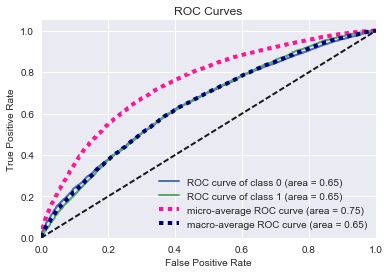

In [153]:
%matplotlib inline

# This is all that's needed for scikit-plot
import matplotlib.pyplot as plt
from scikitplot import classifier_factory

classifier_factory(gs.best_estimator_)

gs.best_estimator_.plot_roc_curve(X.as_matrix(), y, random_state=2)
plt.show()

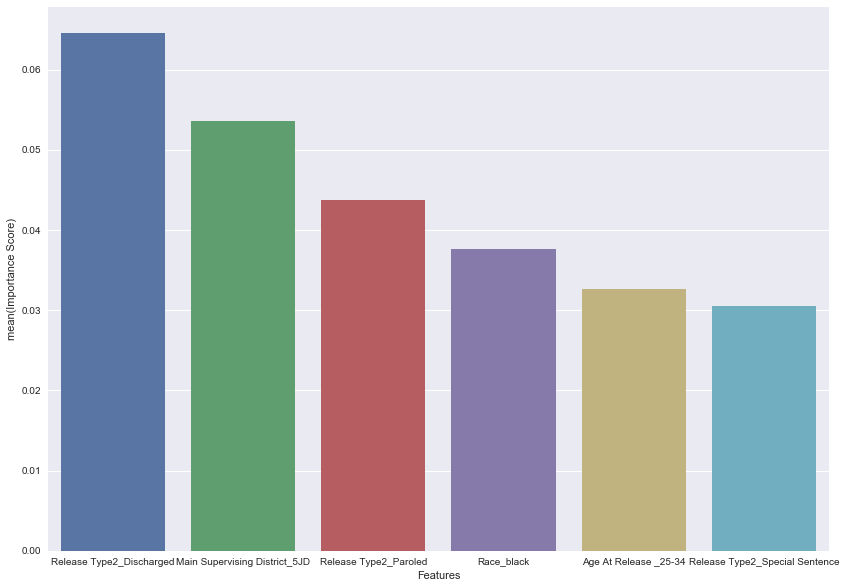

In [154]:
features = X.columns
feature_importances = gs.best_estimator_.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values(by='Importance Score', inplace=True, ascending=False)

#Plot top features

a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(x="Features", y="Importance Score", data=features_df.head(6));

plt.show()

# Gradient Boosting

In [158]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(n_estimators = 20)

In [159]:
model_gb.fit(trainX,trainY)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=20, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [160]:
param_grid = {"loss":['deviance', 'exponential'],
              "max_depth": [3, None],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 3, 10],
              "warm_start": [True, False]}


gs_gb = GridSearchCV(model_gb, param_grid=param_grid)
start = time()
gs_gb.fit(trainX,trainY)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(gs_gb.cv_results_['params'])))
report(gs_gb.cv_results_)

GridSearchCV took 204.49 seconds for 72 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.685 (std: 0.000)
Parameters: {'min_samples_split': 2, 'loss': 'deviance', 'warm_start': True, 'max_depth': 3, 'min_samples_leaf': 10}

Model with rank: 1
Mean validation score: 0.685 (std: 0.000)
Parameters: {'min_samples_split': 2, 'loss': 'deviance', 'warm_start': False, 'max_depth': 3, 'min_samples_leaf': 10}

Model with rank: 1
Mean validation score: 0.685 (std: 0.000)
Parameters: {'min_samples_split': 5, 'loss': 'deviance', 'warm_start': True, 'max_depth': 3, 'min_samples_leaf': 10}

Model with rank: 1
Mean validation score: 0.685 (std: 0.000)
Parameters: {'min_samples_split': 5, 'loss': 'deviance', 'warm_start': False, 'max_depth': 3, 'min_samples_leaf': 10}

Model with rank: 1
Mean validation score: 0.685 (std: 0.000)
Parameters: {'min_samples_split': 10, 'loss': 'deviance', 'warm_start': True, 'max_depth': 3, 'min_samples_leaf': 10}

Model with rank: 1
Mean validati

In [210]:
y_predict_gb = gs_gb.best_estimator_.predict(testX)

In [248]:
from sklearn.metrics import confusion_matrix, classification_report

cnf_mtx = confusion_matrix(testY, y_predict_gb)
print cnf_mtx

print classification_report(testY, y_predict_gb)

[[8745   20]
 [3980   50]]
             precision    recall  f1-score   support

          0       0.69      1.00      0.81      8765
          1       0.71      0.01      0.02      4030

avg / total       0.70      0.69      0.57     12795



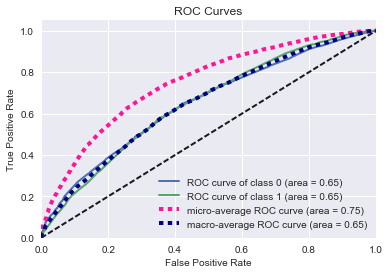

In [161]:
%matplotlib inline

# This is all that's needed for scikit-plot
import matplotlib.pyplot as plt
from scikitplot import classifier_factory

classifier_factory(gs_gb.best_estimator_)

gs_gb.best_estimator_.plot_roc_curve(X.as_matrix(), y, random_state=2)
plt.show()

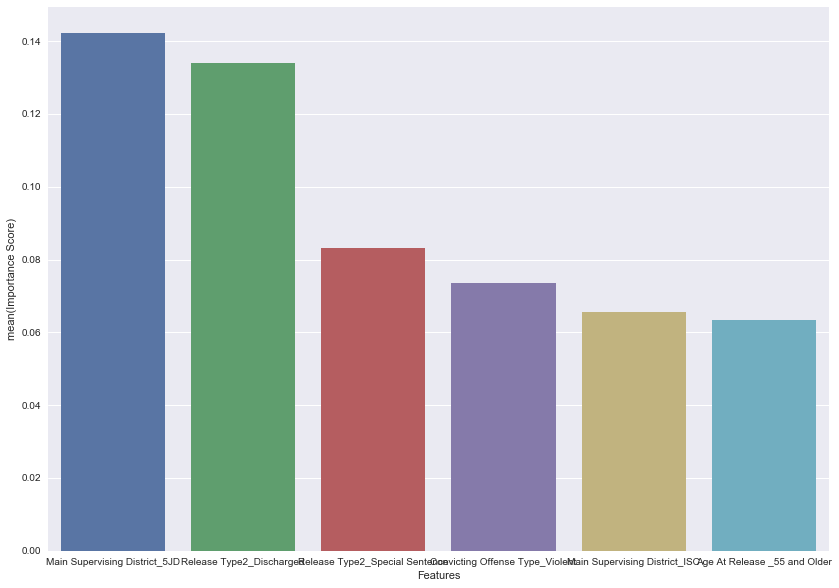

,Features,Importance Score
63,Main Supervising District_5JD,0.142216
11,Release Type2_Discharged,0.133880
13,Release Type2_Special Sentence,0.083250
18,Convicting Offense Type_Violent,0.073648
67,Main Supervising District_ISC,0.065655
7,Age At Release _55 and Older,0.063353


In [164]:
features = X.columns
feature_importances = gs_gb.best_estimator_.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values(by='Importance Score', inplace=True, ascending=False)

#Plot top features

a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(x="Features", y="Importance Score", data=features_df.head(6));

plt.show()

features_df.head(6)